# MGP-DCNN
### Python Implementation of MGP-DCNN 
### Paper : 


# 0] Prerequisites
- Install Pytorch

In [2]:
import torch
import gpytorch
import h5py
import numpy as np
import MGPDCNN         #our package using Keras and Pytorch

Using TensorFlow backend.


### Import the data :

In [16]:
data_file = 'C:/Users/tmb2183/Desktop/myhmc/data/according_Clue_dataset_N_60_Sub_1_T_150_freq_1'

with h5py.File(data_file, 'r') as data:
    y_data = data['x_data'][:]

Set all the hyperparameters

In [17]:
nb_individuals = 5       #number of individuals 
nb_individuals_train = 3  #number of individuals for the training of the DCNN
nb_individuals_val = 1    #number of individuals for the validation of the DCNN
nb_individuals_test = 1   #number of individuals for the test of the DCNN
assert(nb_individuals_train + nb_individuals_val + nb_individuals_test == nb_individuals)

nb_time_steps = 105       #number of time steps
nb_train_time_steps = 70  #time limit for the training (limit between reconstruction and forecast)

nb_selected_points = 70   #number of points selected for the taining of the MGP (< nb_train_time_steps)
nb_input_tasks = 5        #number of tasks selected for the input and output of the MGP = input DCNN
nb_output_tasks = 5       #number of tasks selected for the output of the DCNN

# 1 ] MGP

#### This is the first step of the model. A Multitask Gaussian Process is trained on the input data. 

## 1.1 Prepare the data for the training

In [18]:
y_data = MGPDCNN.data_processing.align_data_on_peak(y_data, length=nb_time_steps, column=0)
print(y_data.shape)

(60, 105, 5)


#### Restrict the data in order to get the right size

In [19]:
y_data = y_data[:nb_individuals, :nb_time_steps]
print(y_data.shape)

(5, 105, 5)


#### (OPTIONAL BUT HIGHLY RECOMMANDED) Scale the Data for the training of the MGP

In [20]:
from sklearn.preprocessing import MinMaxScaler
sklearn_scaler = MinMaxScaler()

You have to specify which blocks will be used for the MGP, in other words the structure of the covariance matrix will be block-diagonal wih respect to those indices. For exampl, if you want independant GPs, use block_indices = [[0],[1],[2],..]
Those indices correspond to the the last axis (the axis that contains nb_input_tasks columns)

In [21]:
block_indices = [[0,1],[2,3,4]]  #Indices of the tasks for each MGP, each sublist is a block in the total covariance matrix
                                 # ---> cardinal should be equal to nb_input  
assert(np.concatenate(block_indices).shape[0] == nb_input_tasks)
nb_blocks = len(block_indices)

#### BUILD THE DATASET :
If you don't want to scale the data, don't specify any argument for 'scaler'. In the other case, the scaler will be parametrized on the training data only and will be returned in order to inverse the scaling after. 


In [22]:
train_x, train_y, test_x, test_y, parametrized_scaler = MGPDCNN.prepare_data_before_GP(y_data,
                                                                  block_indices = block_indices,
                                                                  nb_time_steps = nb_time_steps,
                                                                  nb_train_time_steps = nb_train_time_steps,
                                                                  nb_train_individuals = nb_individuals_train,
                                                                  scaler=sklearn_scaler)

#### The arrays are now torch Tensors (required for Gpytorch)

In [23]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([70]) torch.Size([5, 70, 5])
torch.Size([105]) torch.Size([5, 105, 5])


**Note** that the test set is just an extended time period of the train set. We must keep in mind that the test array will feed the DCNN after. We use here 'train' and 'test' for the delimitation in time between the reconstruction and the prediction. It has nothing to do with the individuals used for the training and the test... (Remember that the MGP is trained on the individual level : same behavior for every individual)

**Note also** that the x values (time) are scaled ! Indeed they are in the range [0,1]

## 1.2  Train the MGP
#### You can trained news MGP and save the ouput OR load the data from a previous dataset depending on the value of  'new_h5' 

In [ ]:
new_h5 = True  # generate a new dataset = training of the MGP

Specify the parameters for the training of the MGP, 'n_iter' represnets the maximal number of iterations for the Adam Optimizer that backpropagates the error

In [38]:
n_iter = 500               # max of iterations for the training of the MGP
learning_rate_gp = 0.02    # learning rate for the trainig of the MGP

This is the time kernel, see gpytorch.kernels to see all the possible kernels, here we aslo set a prior for the period_length parameter : see gpytorch.priors for more info 

In [39]:
time_kernel = gpytorch.kernels.PeriodicKernel(
    period_length_prior = gpytorch.priors.NormalPrior(0.31,0.1))

#### Now let's train the multiple MGPs (one for each individual)

### Precisions:
#### Inputs
- **nb_selected_points** : number of points that are used for the training of the MGP. They are selected randomly BUT (see next line)
- **nb_peaks_selected** :  you can specify how many samples from the peaks you want to have in you subselection of points, the peaks are selected from the first task of the first block. if this value is different from 0, the time steps that correspond to the peaks are necessarly choosen. If nb_peaks_selected = 0, the time selection is totaly random.
- **save_h5** :indiciates whether or not you want to save the ouputs
- **activate_plot** : plot the covariances matrix per bloc, the loss per block and the regressions curves for each individual (each MGP)
- **smart_end** : stops the training when the loss starts increasing too much --> avoid classic behaviors of MGP that start to have a very noisy loss when they start to overfit
- **nb_peaks_selected** :

#### Output
 - **h5_dataset_path** is the path of the h5_file that contains all the output means and coavariances matrix per bloc of each individual. At this step, 

LENGTH between selectec peaks : 27
###########      INDIVIDUAL 0    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 88.847
Iter 101/500 - Loss: 19.203
Iter 201/500 - Loss: -47.720
Iter 301/500 - Loss: -83.590
### BLOCK 1 ###
Iter 1/500 - Loss: 84.805
Iter 101/500 - Loss: 19.884
Iter 201/500 - Loss: -47.175


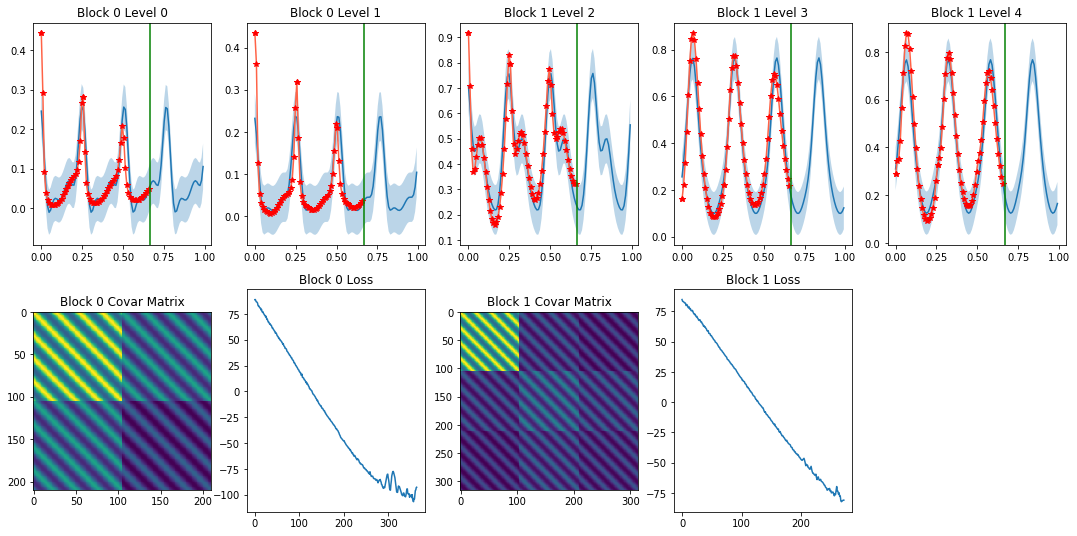

LENGTH between selectec peaks : 27
###########      INDIVIDUAL 1    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 82.772
Iter 101/500 - Loss: 24.670
Iter 201/500 - Loss: -21.301
### BLOCK 1 ###
Iter 1/500 - Loss: 85.894
Iter 101/500 - Loss: 21.467
Iter 201/500 - Loss: -41.840


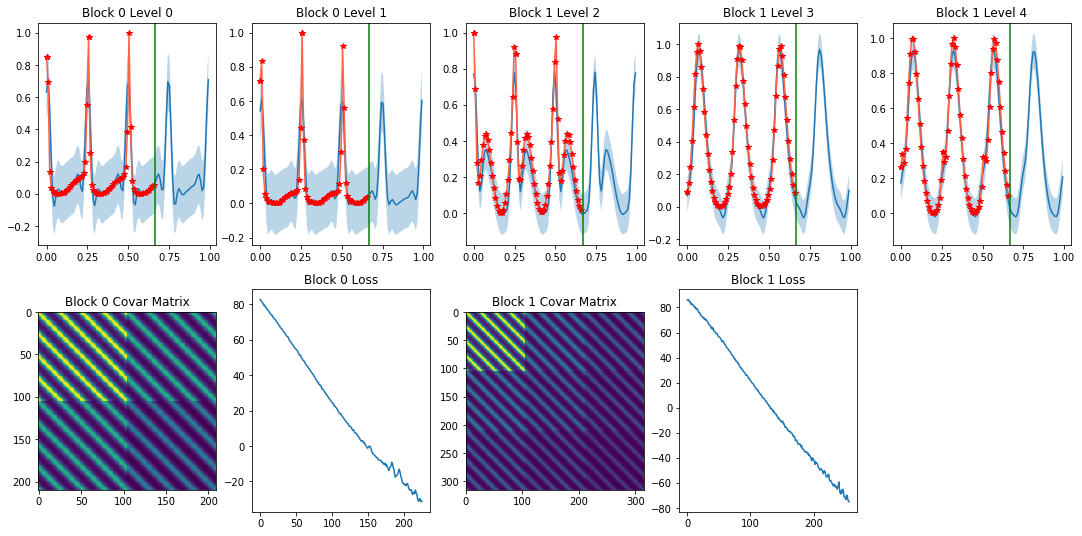

LENGTH between selectec peaks : 25
###########      INDIVIDUAL 2    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 85.110
Iter 101/500 - Loss: 17.615
Iter 201/500 - Loss: -58.340
Iter 301/500 - Loss: -129.752
Iter 401/500 - Loss: -187.083
### BLOCK 1 ###
Iter 1/500 - Loss: 83.306
Iter 101/500 - Loss: 18.031
Iter 201/500 - Loss: -54.753
Iter 301/500 - Loss: -122.010


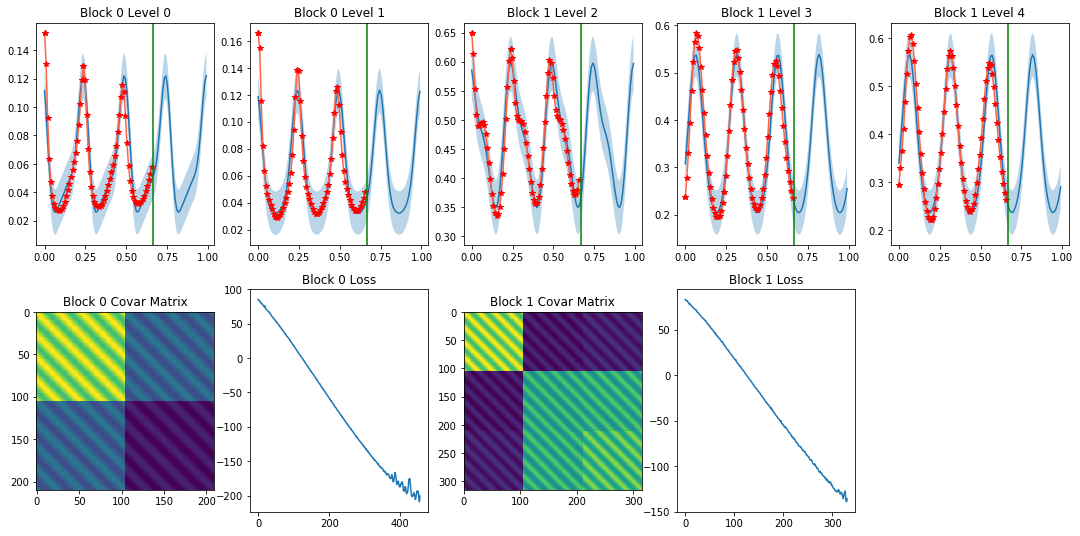

LENGTH between selectec peaks : 26
###########      INDIVIDUAL 3    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 80.304
Iter 101/500 - Loss: 15.715
Iter 201/500 - Loss: -60.017
Iter 301/500 - Loss: -133.164
Iter 401/500 - Loss: -200.294
### BLOCK 1 ###
Iter 1/500 - Loss: 81.109
Iter 101/500 - Loss: 17.248
Iter 201/500 - Loss: -56.428
Iter 301/500 - Loss: -127.218


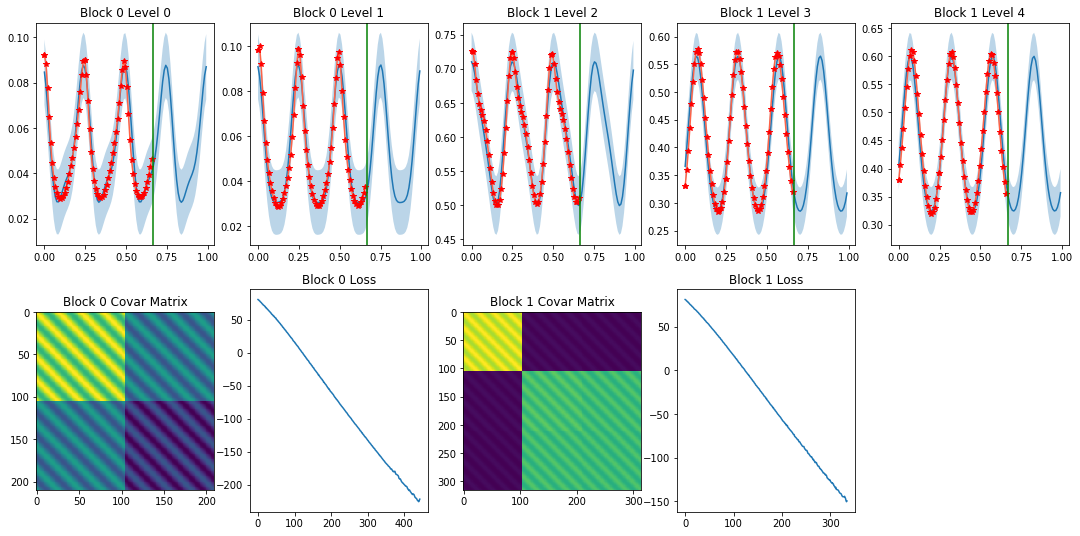

LENGTH between selectec peaks : 27
###########      INDIVIDUAL 4    ###########
### BLOCK 0 ###
Iter 1/500 - Loss: 81.195
Iter 101/500 - Loss: 17.184
Iter 201/500 - Loss: -55.155
Iter 301/500 - Loss: -110.912
### BLOCK 1 ###
Iter 1/500 - Loss: 82.383
Iter 101/500 - Loss: 21.655


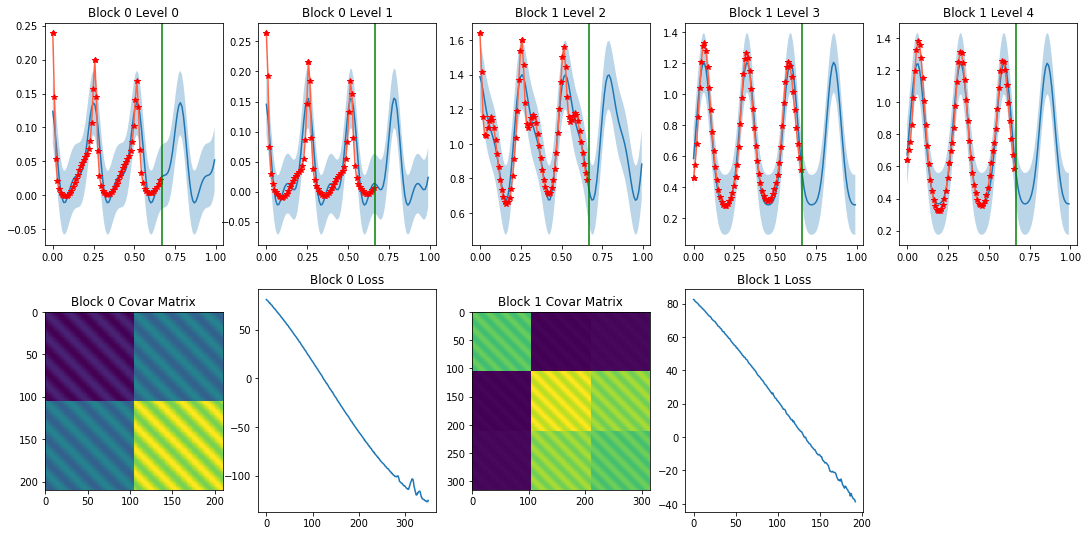

OSError: Unable to create file (unable to open file: name = 'output_models/OUTPUT_MGP_Nb_individuals_5_Time_105_Selected_points_70_Nb_blocks_2_Nb_peaks_0', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [40]:
if new_h5 == True:
    h5_dataset_path = MGPDCNN.train_Block_MGP_multiple_individuals(train_x, train_y, block_indices, test_x,
                                                       kernel=time_kernel, learning_rate=learning_rate_gp, n_iter=n_iter,
                                                       nb_selected_points = nb_selected_points, nb_peaks_selected = 0,
                                                       save_h5 = True, activate_plot=True, smart_end = True)

## 1. 3 Load the data from a trained MGP

#### You can here specify the path of the h5 file you want to load ;

In [41]:
if new_h5 == False:
    h5_dataset_path = 'output_models/OUTPUT_MGP_Nb_individuals_%d_Time_%d_Selected_points_%d_Nb_blocks_%d_Nb_peaks_%d'\
                      %(nb_individuals, nb_time_steps, nb_selected_points, nb_blocks, 0)
    print(h5_dataset_path)

In [ ]:
nb_samples_per_id = 10          # number of posteriors samples we want to drawn from each individual distribution